In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous

#X_motion_CoM = np.vstack((X_motion_CoM_acceleration, X_motion_CoM_continuous))
#Y_motion_CoM = np.vstack((Y_motion_CoM_acceleration, Y_motion_CoM_continuous))
X_motion_CoM = X_motion_CoM_continuous
Y_motion_CoM = Y_motion_CoM_continuous
print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

no stored variable or alias X_motion_CoM_acceleration
no stored variable or alias Y_motion_CoM_acceleration
(4626, 61)
(4626, 3)


In [6]:
X_motion_CoM[0, :]

array([ 1.00000001e-01,  0.00000000e+00,  0.00000000e+00,  2.37123758e-01,
        1.29492521e-01, -3.96473199e-01,  2.35636503e-01, -1.29854202e-01,
       -3.99378240e-01, -2.60216773e-01,  1.31444916e-01, -4.01650101e-01,
       -2.64598429e-01, -1.25929505e-01, -3.96399885e-01, -4.38515663e+00,
       -2.27757311e+00,  4.47428584e-01,  1.81728564e-02,  1.36686745e-03,
        5.76423630e-02, -4.24227454e-02, -4.24382426e-02, -2.46270886e-03,
        3.04491948e-02, -2.82363570e-03,  6.94693774e-02, -1.58019885e-02,
       -6.27183467e-02, -7.79861882e-02, -5.76661639e-02,  5.22246808e-02,
        7.75936916e-02,  5.87101281e-02, -1.36440182e+00, -4.05879021e-01,
        3.22345674e-01,  8.18385556e-02,  1.00004278e-01, -6.50247633e-01,
        7.48651862e-01, -1.93399582e-02, -5.69995358e-03,  1.74269461e-01,
        1.02392709e-01, -9.53243600e-02, -8.91508217e-02, -1.29498425e-03,
       -9.95984417e-04, -1.21180257e-02,  9.99925256e-01, -2.56564445e-03,
       -2.02320656e-03, -

# Multivariate Linear Regression (Foot prediction)

In [7]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [10]:
# Entries where FL foot is swinging
idx_fl_rr_swinging = np.where(X_motion_CoM[:, 54] == 1)[0]
X_motion_CoM_FL_RR = X_motion_CoM[idx_fl_rr_swinging]
Y_motion_CoM_FL_RR = Y_motion_CoM[idx_fl_rr_swinging]

In [11]:
idx_fl_rr_swinging.shape

(2313,)

## Predict CoM -> x

### Linear Regression

In [37]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, -3:], # Current motion command
               X_motion_CoM_FL_RR[:, 3:5], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 6:8], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_x = LinearRegression()

# Fit the model
model_fl_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9937186751502852
RMSE:  0.006380133136346801
The lowest error is:  9.482226716400755e-06
The highest error is:  0.03390773597289426
The avg. error is:  0.004265321567664014


In [38]:
model_fl_com_x.coef_

array([[ 1.25398583e-01, -1.11022302e-16, -7.82893958e-03,
        -1.02531022e-01,  5.74604179e-03,  3.57320177e-01,
         3.36974323e-01,  5.79906712e-01,  3.30828422e-03,
        -1.04625592e-01, -2.04923689e-01]])

In [39]:
model_fl_com_x.intercept_

array([0.07940029])

In [21]:
input_ = np.array([[0.0,0.0,0.0,0.1,0.0,0.0,0.2399, 0.134, 0.2399, -0.134, -0.2399, 0.134, -0.2399, -0.134]])
input_ @ model_fl_com_x.coef_.T + model_fl_com_x.intercept_

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 15 is different from 14)

Text(0, 0.5, 'Predictions')

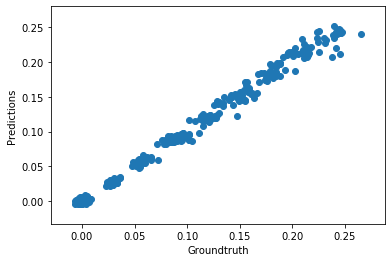

In [40]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [41]:
#%store model_fl_com_x

In [42]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [43]:
# Save model
#joblib.dump(model_fl_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_x.sav")

## Predict CoM -> y

### Linear Regression

In [44]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, -3:], # Current motion command
               X_motion_CoM_FL_RR[:, 3:5], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 6:8], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_y = LinearRegression()

# Fit the model
model_fl_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.3184630718234507
RMSE:  0.002336077508788824
The lowest error is:  1.6656788027848146e-05
The highest error is:  0.014230614631658534
The avg. error is:  0.0017491262619547148


In [45]:
model_fl_com_y.coef_

array([[-1.23366948e-02,  1.38777878e-17, -1.55666770e-02,
         8.58511635e-02, -2.97832585e-01,  1.09202528e-01,
         7.67324166e-02, -9.38130513e-02,  1.95899074e-02,
        -1.24305755e-01, -1.20850126e-01]])

In [46]:
model_fl_com_y.intercept_

array([-0.07523869])

Text(0, 0.5, 'Predictions')

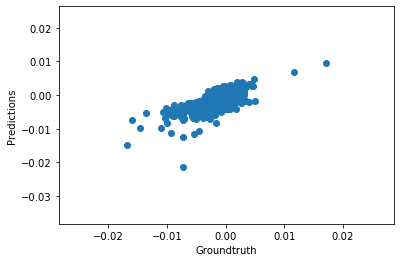

In [47]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [48]:
#%store model_fl_com_y

In [49]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [50]:
# Save model
#joblib.dump(model_fl_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_y.sav")

## Predict CoM -> Yaw

In [51]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, -3:], # Current motion command
               X_motion_CoM_FL_RR[:, 3:5], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 6:8], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_theta = LinearRegression()

# Fit the model
model_fl_com_theta.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_theta.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9810381755472243
RMSE:  0.009251938626828483
The lowest error is:  6.995558905088101e-06
The highest error is:  0.07537305109486264
The avg. error is:  0.005410757441712553


In [52]:
model_fl_com_theta.coef_

array([[ 3.86867956e-03, -2.63677968e-16,  9.55657783e-02,
         3.16491570e-01, -5.36672866e-01,  1.33546040e+00,
         7.03196017e-01, -1.40925453e+00, -1.25686429e+00,
        -3.46997611e-01,  2.70843304e-01]])

In [53]:
model_fl_com_theta.intercept_

array([-0.4904179])

Text(0, 0.5, 'Predictions')

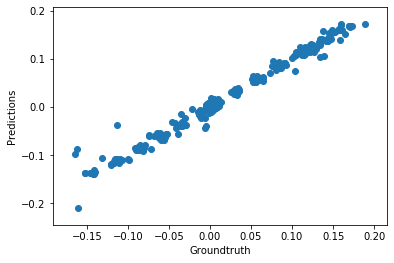

In [54]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")